In [2]:
import numpy as np

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [4]:
data_pre_path = '../../data/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'coarse_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])

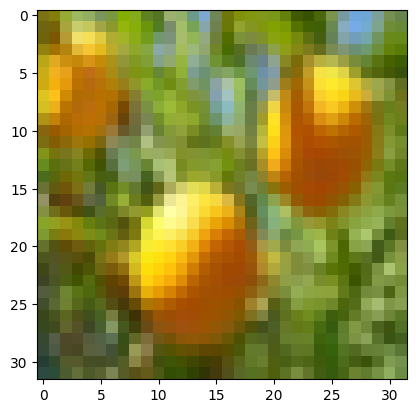

In [5]:
import matplotlib.pyplot as plt

img = data_train.reshape(50_000, 3, 32, 32).transpose(0, 2, 3, 1)[69]
plt.imshow(img)

In [6]:
from PIL import Image

Image.fromarray(img).save('img3.png')


In [5]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class CIFAR_train(Dataset):
    def __init__(self, transform = None):
        self.data_path = "../../data/train"
        self.data_dict = unpickle(self.data_path)
        self.data = self.data_dict[b'data']
        self.label = np.array(self.data_dict[b'coarse_labels'])
        self.transform = transform

    def __getitem__(self,index):
        img = self.data[index]
        img = img.reshape(3,32,32)
        img = img.transpose(2,1,0) 
        if self.transform :
            img = self.transform(Image.fromarray(img))
        return img , self.label[index]
    
    def __len__(self):
        return len(self.data)
    
class CIFAR_test(Dataset):
    def __init__(self, transform = None):
        self.data_path = "../../data/test"
        self.data_dict = unpickle(self.data_path)
        self.data = self.data_dict[b'data']
        self.label = np.array(self.data_dict[b'coarse_labels'])
        self.transform = transform

    def __getitem__(self,index):
        img = self.data[index]
        img = img.reshape(3,32,32)
        img = img.transpose(2,1,0) 
        if self.transform :
            img = self.transform(Image.fromarray(img))
        return img , self.label[index]
    
    def __len__(self):
        return len(self.data)

In [6]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

batch_size = 1024

train_data = CIFAR_train(transform)
test_data = CIFAR_test(transform)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_134028/3531982884.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.3260038].


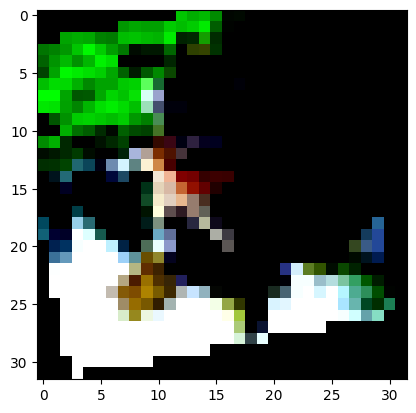

In [7]:
img, label = train_dl.dataset.__getitem__(0)
plt.imshow(img.T)   

In [8]:
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [13]:
from torch import nn, optim
from torchvision import models

num_classes = 20  # Adjust based on your dataset's number of classes
model = models.resnet18(pretrained=True)

model

/home/sv-cheats-1/Documents/PMLDL/Deployment/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sv-cheats-1/Documents/PMLDL/Deployment/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc = nn.Linear(model.fc.in_features, 20)  # Modify for coarse classes

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [11]:
from tqdm import tqdm

def train(
    epochs,
    model,
    loss_fn,
    optimizer,
    train_dl,
    test_dl,
):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train(True)
        running_loss = 0.0
        train_total = 0
        train_correct = 0

        # Training loop with progress bar
        for i, data in enumerate(tqdm(train_dl, desc=f"Epoch {epoch + 1}/{epochs} - Training")):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Accuracy tracking during training
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_dl)
        train_accuracy = 100 * train_correct / train_total
        print(f"Epoch {epoch+1}/{epoch} - Avg Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_total = 0
        val_correct = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(test_dl, desc=f"Epoch {epoch + 1}/{epochs} - Validation")):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy tracking during validation
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(test_dl)
        val_accuracy = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}/{epoch} - Avg Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

train(
    10,
    model,
    loss_fn,
    optimizer,
    train_dl,
    test_dl,
)

Epoch 1/10 - Training:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/10 - Training: 100%|██████████| 49/49 [01:08<00:00,  1.39s/it]


Epoch 1/0 - Avg Train Loss: 2.1955, Train Accuracy: 31.99%


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch 1/0 - Avg Val Loss: 1.9964, Val Accuracy: 38.43%



Epoch 2/10 - Training: 100%|██████████| 49/49 [01:07<00:00,  1.37s/it]


Epoch 2/1 - Avg Train Loss: 1.7378, Train Accuracy: 45.01%


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch 2/1 - Avg Val Loss: 1.7848, Val Accuracy: 43.81%



Epoch 3/10 - Training: 100%|██████████| 49/49 [01:07<00:00,  1.38s/it]


Epoch 3/2 - Avg Train Loss: 1.5956, Train Accuracy: 49.18%


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Epoch 3/2 - Avg Val Loss: 1.6610, Val Accuracy: 48.18%



Epoch 4/10 - Training: 100%|██████████| 49/49 [01:07<00:00,  1.38s/it]


Epoch 4/3 - Avg Train Loss: 1.5046, Train Accuracy: 52.11%


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Epoch 4/3 - Avg Val Loss: 1.6205, Val Accuracy: 48.57%



Epoch 5/10 - Training: 100%|██████████| 49/49 [01:07<00:00,  1.38s/it]


Epoch 5/4 - Avg Train Loss: 1.4287, Train Accuracy: 54.34%


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 5/4 - Avg Val Loss: 1.6082, Val Accuracy: 49.71%



Epoch 6/10 - Training: 100%|██████████| 49/49 [01:08<00:00,  1.39s/it]


Epoch 6/5 - Avg Train Loss: 1.3708, Train Accuracy: 56.31%


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Epoch 6/5 - Avg Val Loss: 1.6229, Val Accuracy: 49.31%



Epoch 7/10 - Training: 100%|██████████| 49/49 [01:07<00:00,  1.38s/it]


Epoch 7/6 - Avg Train Loss: 1.3257, Train Accuracy: 57.40%


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Epoch 7/6 - Avg Val Loss: 1.5372, Val Accuracy: 51.15%



Epoch 8/10 - Training:  35%|███▍      | 17/49 [00:23<00:44,  1.38s/it]